<a href="https://colab.research.google.com/github/vikasg964/Stock_price_forcasting/blob/main/Time_Series_Forecasting1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

Helper Functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
  

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [ ]:
df_stock = pd.read_csv('/content/CSC215_P2_Stock_Price.csv')
df_stock.shape
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


Data cleaning

In [ ]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock

# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)

After dropping the coloumns date and Adj_close

In [ ]:
df_stock_new.shape

(4392, 5)

In [ ]:
df_stock.shape

(4392, 7)

After removing null values

In [ ]:
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [ ]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


Normalize Numerical Features

In [ ]:
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [ ]:
#print first  5 rows in new csv file to check for normalizing
print(df_stock_new.head())

       Open      High       Low     Close    Volume         y
0 -0.894311 -0.885122 -0.892408 -0.884464  1.104938  4.125000
1 -0.883863 -0.886157 -0.886076 -0.888122 -0.497357  4.015625
2 -0.888042 -0.889261 -0.887659 -0.888645 -0.892319  4.000000
3 -0.888042 -0.890295 -0.891353 -0.893870 -0.000263  3.843750
4 -0.896922 -0.899088 -0.906655 -0.909023  3.729791  3.390625


In [ ]:
# Set all column other than y as input or 'x'
x = df_stock_new.iloc[:,df_stock_new.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_stock_new['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


Data Transformation

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

Shape of x_seq: (4386, 6, 1, 5)
Shape of y_seq: (4386,)



Model trained for adam optimizer and sigmoid activation function for 6 days: 

Epoch 1/200
96/96 - 0s - loss: 1776.0906 - val_loss: 1579.9673
Epoch 2/200
96/96 - 0s - loss: 1605.0583 - val_loss: 1461.1920
Epoch 3/200
96/96 - 0s - loss: 1498.8264 - val_loss: 1366.7117
Epoch 4/200
96/96 - 0s - loss: 1401.0507 - val_loss: 1279.3488
Epoch 5/200
96/96 - 0s - loss: 1317.1068 - val_loss: 1201.6614
Epoch 6/200
96/96 - 0s - loss: 1242.3030 - val_loss: 1139.0343
Epoch 7/200
96/96 - 0s - loss: 1182.4733 - val_loss: 1087.2634
Epoch 8/200
96/96 - 0s - loss: 1132.0540 - val_loss: 1042.4916
Epoch 9/200
96/96 - 0s - loss: 1080.1685 - val_loss: 973.5828
Epoch 10/200
96/96 - 0s - loss: 1004.8411 - val_loss: 908.9771
Epoch 11/200
96/96 - 0s - loss: 937.4683 - val_loss: 843.6572
Epoch 12/200
96/96 - 0s - loss: 875.4872 - val_loss: 789.9229
Epoch 13/200
96/96 - 0s - loss: 822.3867 - val_loss: 741.9447
Epoch 14/200
96/96 - 0s - loss: 774.5799 - val_

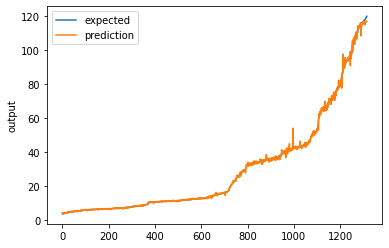

In [ ]:
SEQUENCE_SIZE = 6
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4386,30)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 6 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4387, 5, 1, 5)
Shape of y_seq: (4387,)



Model trained for adam optimizer and sigmoid activation function for 5 days: 

Epoch 1/200
96/96 - 0s - loss: 1707.8301 - val_loss: 1536.6593
Epoch 2/200
96/96 - 0s - loss: 1542.8855 - val_loss: 1424.5043
Epoch 3/200
96/96 - 0s - loss: 1439.1992 - val_loss: 1330.5331
Epoch 4/200
96/96 - 0s - loss: 1349.7511 - val_loss: 1252.3551
Epoch 5/200
96/96 - 0s - loss: 1274.7499 - val_loss: 1181.3494
Epoch 6/200
96/96 - 0s - loss: 1206.1285 - val_loss: 1121.4521
Epoch 7/200
96/96 - 0s - loss: 1149.8401 - val_loss: 1071.2496
Epoch 8/200
96/96 - 0s - loss: 1098.8716 - val_loss: 1016.2255
Epoch 9/200
96/96 - 0s - loss: 1024.2087 - val_loss: 932.6277
Epoch 10/200
96/96 - 0s - loss: 950.9521 - val_loss: 867.0416
Epoch 11/200
96/96 - 0s - loss: 888.7067 - val_loss: 810.2878
Epoch 12/200
96/96 - 0s - loss: 833.2883 - val_loss: 758.2292
Epoch 13/200
96/96 - 0s - loss: 783.0266 - val_loss: 712.2979
Epoch 14/200
96/96 - 0s - loss: 737.5755 - val_l

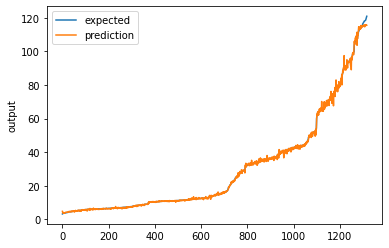

In [ ]:
SEQUENCE_SIZE = 5
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4387,25)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 5 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4388, 4, 1, 5)
Shape of y_seq: (4388,)



Model trained for adam optimizer and sigmoid activation function for 4 days: 

Epoch 1/200
96/96 - 0s - loss: 1713.1572 - val_loss: 1522.1215
Epoch 2/200
96/96 - 0s - loss: 1515.1342 - val_loss: 1400.5811
Epoch 3/200
96/96 - 0s - loss: 1414.6029 - val_loss: 1319.9279
Epoch 4/200
96/96 - 0s - loss: 1338.6809 - val_loss: 1254.1161
Epoch 5/200
96/96 - 0s - loss: 1274.3002 - val_loss: 1197.8528
Epoch 6/200
96/96 - 0s - loss: 1218.2216 - val_loss: 1148.3492
Epoch 7/200
96/96 - 0s - loss: 1169.0715 - val_loss: 1104.9779
Epoch 8/200
96/96 - 0s - loss: 1125.4156 - val_loss: 1064.8596
Epoch 9/200
96/96 - 0s - loss: 1070.7229 - val_loss: 991.2226
Epoch 10/200
96/96 - 0s - loss: 997.3159 - val_loss: 929.8403
Epoch 11/200
96/96 - 0s - loss: 937.9483 - val_loss: 876.2505
Epoch 12/200
96/96 - 0s - loss: 884.6305 - val_loss: 827.6893
Epoch 13/200
96/96 - 0s - loss: 836.1180 - val_loss: 783.7401
Epoch 14/200
96/96 - 0s - loss: 791.8176 - val_l

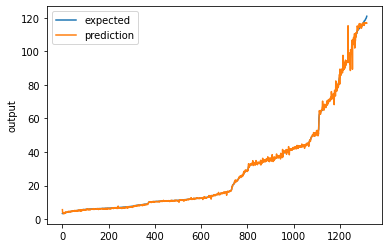

In [ ]:
SEQUENCE_SIZE = 4
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4388,20)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 4 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4389, 3, 1, 5)
Shape of y_seq: (4389,)



Model trained for adam optimizer and sigmoid activation function for 3 days: 

Epoch 1/200
96/96 - 0s - loss: 1808.7760 - val_loss: 1520.5403
Epoch 2/200
96/96 - 0s - loss: 1632.7289 - val_loss: 1414.8776
Epoch 3/200
96/96 - 0s - loss: 1538.3809 - val_loss: 1338.6251
Epoch 4/200
96/96 - 0s - loss: 1462.7002 - val_loss: 1274.1417
Epoch 5/200
96/96 - 0s - loss: 1396.7954 - val_loss: 1216.9702
Epoch 6/200
96/96 - 0s - loss: 1338.2209 - val_loss: 1166.6923
Epoch 7/200
96/96 - 0s - loss: 1285.8705 - val_loss: 1121.6896
Epoch 8/200
96/96 - 0s - loss: 1238.8004 - val_loss: 1081.0770
Epoch 9/200
96/96 - 0s - loss: 1190.7998 - val_loss: 1036.6913
Epoch 10/200
96/96 - 0s - loss: 1146.1628 - val_loss: 1001.6669
Epoch 11/200
96/96 - 0s - loss: 1109.6327 - val_loss: 972.4958
Epoch 12/200
96/96 - 0s - loss: 1078.1824 - val_loss: 947.1586
Epoch 13/200
96/96 - 0s - loss: 1043.1241 - val_loss: 884.6943
Epoch 14/200
96/96 - 0s - loss: 964.6477 -

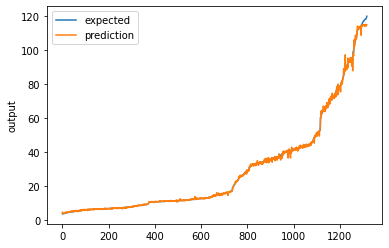

In [ ]:
SEQUENCE_SIZE = 3
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4389,15)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 3 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4390, 2, 1, 5)
Shape of y_seq: (4390,)



Model trained for adam optimizer and sigmoid activation function for 2 days: 

Epoch 1/200
97/97 - 0s - loss: 1693.7365 - val_loss: 1555.0774
Epoch 2/200
97/97 - 0s - loss: 1509.2526 - val_loss: 1441.6558
Epoch 3/200
97/97 - 0s - loss: 1412.2130 - val_loss: 1354.8613
Epoch 4/200
97/97 - 0s - loss: 1322.2311 - val_loss: 1270.9543
Epoch 5/200
97/97 - 0s - loss: 1247.5488 - val_loss: 1206.2831
Epoch 6/200
97/97 - 0s - loss: 1186.2140 - val_loss: 1151.1632
Epoch 7/200
97/97 - 0s - loss: 1134.9550 - val_loss: 1105.5944
Epoch 8/200
97/97 - 0s - loss: 1091.5079 - val_loss: 1067.0511
Epoch 9/200
97/97 - 0s - loss: 1053.9471 - val_loss: 1033.7256
Epoch 10/200
97/97 - 0s - loss: 1022.5269 - val_loss: 1006.1433
Epoch 11/200
97/97 - 0s - loss: 996.5042 - val_loss: 983.1583
Epoch 12/200
97/97 - 0s - loss: 969.0651 - val_loss: 927.5352
Epoch 13/200
97/97 - 0s - loss: 868.1606 - val_loss: 825.8644
Epoch 14/200
97/97 - 0s - loss: 804.1523 - va

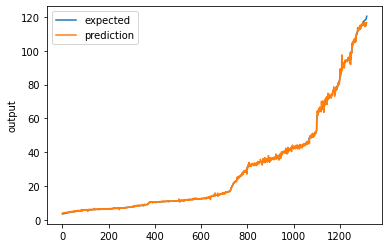

In [ ]:
SEQUENCE_SIZE = 2
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4390,10)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 2 days: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)

Shape of x_seq: (4391, 1, 1, 5)
Shape of y_seq: (4391,)



Model trained for adam optimizer and sigmoid activation function for 1 day: 

Epoch 1/200
97/97 - 0s - loss: 1696.7841 - val_loss: 1586.0634
Epoch 2/200
97/97 - 0s - loss: 1539.3406 - val_loss: 1479.3337
Epoch 3/200
97/97 - 0s - loss: 1434.2936 - val_loss: 1375.4939
Epoch 4/200
97/97 - 0s - loss: 1330.7723 - val_loss: 1275.8475
Epoch 5/200
97/97 - 0s - loss: 1237.9127 - val_loss: 1196.6490
Epoch 6/200
97/97 - 0s - loss: 1166.6377 - val_loss: 1135.3765
Epoch 7/200
97/97 - 0s - loss: 1108.9053 - val_loss: 1085.4729
Epoch 8/200
97/97 - 0s - loss: 1063.1688 - val_loss: 1045.9408
Epoch 9/200
97/97 - 0s - loss: 1026.1609 - val_loss: 1013.5386
Epoch 10/200
97/97 - 0s - loss: 995.8453 - val_loss: 987.7545
Epoch 11/200
97/97 - 0s - loss: 971.0417 - val_loss: 966.6640
Epoch 12/200
97/97 - 0s - loss: 950.9404 - val_loss: 950.0311
Epoch 13/200
97/97 - 0s - loss: 935.4188 - val_loss: 937.1868
Epoch 14/200
97/97 - 0s - loss: 923.0553 - val_l

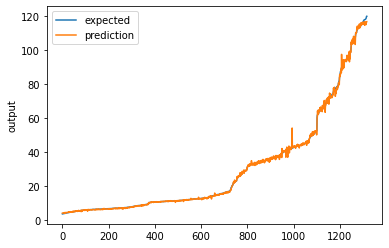

In [ ]:
SEQUENCE_SIZE = 1
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))


x_seq_2d = x_seq.reshape(4391,5)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

X_train.shape

X_test.shape

Y_train.shape

Y_test.shape

type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

# 7. Applying Neural networks

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

print("\n\n\nModel trained for adam optimizer and sigmoid activation function for 1 day: \n")
        
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred = model.predict(X_test)
        
        
# Measure MSE error.  
mse = metrics.mean_squared_error(pred,Y_test)
print("\n\nFinal score (MSE): {}".format(mse))
        
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
print("Final score (RMSE): {}".format(rmse))
        
chart_regression(pred.flatten(),Y_test,sort=True)